In [1]:
# Jesus Torres-Carbajal
# Western Governors University
# Data Science Capstone — D606
# 7/27/2025

# Capstone Project: Regression Analysis of EV Charger Coverage

In [ ]:
# Import required libraires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from datetime import timedelta

# File structure libraries
from pathlib import Path

# Import libraries needed for RF Model
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer

# Import stats libraries
import scipy.stats as stats

## Data Cleaning

In [ ]:
# Set base path
BASE_PATH = Path('Public Datasets')

# Import datasets
population_df = pd.read_csv(BASE_PATH / 'Population_ZIP/ACSDT5Y2023.B01003-Data.csv')
median_income_df = pd.read_csv(BASE_PATH / 'Median_ZIP/ACSDT5Y2023.B19013-Data.csv')
homeowner_renter_df = pd.read_csv(BASE_PATH / 'Homeowner_Renter_ZIP/ACSDT5Y2023.B25003-Data.csv')
urban_rural_df = pd.read_csv(BASE_PATH / 'Urban_Rural_ZIP/RUCA2010zipcode.csv')
ev_ports_df = pd.read_csv(BASE_PATH / 'EV_Chargers/alt_fuel_stations (Aug 1 2025).csv')
wa_evs_df = pd.read_csv(BASE_PATH / 'WA_EVs/WA_Electric_Vehicle_Population_Data.csv')
or_evs_df = pd.read_csv(BASE_PATH / 'OR_EVs/ODOT-EV-Data.csv')
ca_evs_df = pd.read_csv(BASE_PATH / 'CA_EVs/CA_Vehicle_Population_Last_updated_04-30-2025_ada.csv')


/var/folders/1d/p9c9hk_d1b92sr1fjklgb_qw0000gn/T/ipykernel_48244/3655392010.py:10: DtypeWarning: Columns (6,20,31,46,69,74) have mixed types. Specify dtype option on import or set low_memory=False.
  ev_ports_df = pd.read_csv(BASE_PATH / 'EV_Chargers/alt_fuel_stations (Aug 1 2025).csv')


### Formating Datasets Before Joining

In [7]:
# Population dataset before cleaning
# Print head of Dataset
population_df.head()

,GEO_ID,NAME,B01003_001E,B01003_001M,Unnamed: 4
0,Geography,Geographic Area Name,Estimate!!Total,Margin of Error!!Total,NaN
1,860Z200US00601,ZCTA5 00601,16721,477,NaN
2,860Z200US00602,ZCTA5 00602,37510,263,NaN
3,860Z200US00603,ZCTA5 00603,48317,1021,NaN
4,860Z200US00606,ZCTA5 00606,5435,331,NaN


In [8]:
# Format Population

# Format column names
population_df = population_df.rename(columns={'NAME': 'ZIP Code',
                                              'B01003_001E': 'Population'})

# Selected columns
population_df = population_df[['ZIP Code', 'Population']]


# Drop informational row
population_df = population_df.drop(0).reset_index(drop=True)

# Clean ZIP Code column for joining
population_df['ZIP Code'] = population_df['ZIP Code'].str.replace(
    'ZCTA5 ',
    '',
    regex=False
    )

# Print head of Dataset and number of duplicates
print('Duplicate ZIP Codes:')
print(population_df.duplicated(subset='ZIP Code').sum())
population_df.head()

Duplicate ZIP Codes:
0


,ZIP Code,Population
0,00601,16721
1,00602,37510
2,00603,48317
3,00606,5435
4,00610,25413


In [9]:
# Format Median Household Income

# Format column names
median_income_df = median_income_df.rename(
    columns={'NAME': 'ZIP Code',
             'B19013_001E': 'Median Household Income'}
    )

# Select columns
median_income_df = median_income_df[['ZIP Code', 'Median Household Income']]

# Drop informational row
median_income_df = median_income_df.drop(0).reset_index(drop=True)

# Clean ZIP Code column for joining
median_income_df['ZIP Code'] = median_income_df['ZIP Code'].str.replace(
    'ZCTA5 ',
    '',
    regex=False
    )

# Print head of Dataset and number of duplicates
print('Duplicate ZIP Codes:')
print(median_income_df.duplicated(subset='ZIP Code').sum())
median_income_df.head()

Duplicate ZIP Codes:
0


,ZIP Code,Median Household Income
0,00601,18571
1,00602,21702
2,00603,19243
3,00606,20226
4,00610,23732


In [10]:
# Format Homeowner and Renter Rates
homeowner_renter_df = homeowner_renter_df.rename(columns={'NAME': 'ZIP Code'})

# Convert the columns to numeric types, coercing errors to NaNs
homeowner_renter_df['B25003_001E'] = pd.to_numeric(
    homeowner_renter_df['B25003_001E'],
    errors='coerce'
    )

homeowner_renter_df['B25003_002E'] = pd.to_numeric(
    homeowner_renter_df['B25003_002E'],
    errors='coerce'
    )

homeowner_renter_df['B25003_003E'] = pd.to_numeric(
    homeowner_renter_df['B25003_003E'],
    errors='coerce'
    )

# Replace 0 with NaN in the denominator to avoid division by zero
denom = homeowner_renter_df['B25003_001E'].replace(0, np.nan)

# Create Homeownership/Renter Occupanacy Rate Columns
homeowner_renter_df['Homeownership Rate'] = homeowner_renter_df['B25003_002E'] / denom
homeowner_renter_df['Renter Occupancy Rate'] = homeowner_renter_df['B25003_003E'] / denom

# Select columns
homeowner_renter_df = homeowner_renter_df[['ZIP Code', 'Homeownership Rate',
                                            'Renter Occupancy Rate']]

# Drop informational row
homeowner_renter_df = homeowner_renter_df.drop(0).reset_index(drop=True)

# Clean ZIP Code column for joining
homeowner_renter_df['ZIP Code'] = homeowner_renter_df['ZIP Code'].str.replace(
    'ZCTA5 ',
    '',
    regex=False
    )

# Print head of Dataset and number of duplicates
print('Duplicate ZIP Codes:')
print(homeowner_renter_df.duplicated(subset='ZIP Code').sum())
homeowner_renter_df.head()

Duplicate ZIP Codes:
0


,ZIP Code,Homeownership Rate,Renter Occupancy Rate
0,00601,0.695420,0.304580
1,00602,0.752670,0.247330
2,00603,0.570610,0.429390
3,00606,0.768573,0.231427
4,00610,0.725843,0.274157


In [11]:
# Print RUCA dataset bfore Cleaning
print('Duplicate ZIP Codes:')
print(urban_rural_df.duplicated(subset="''ZIP_CODE''").sum())
urban_rural_df.head()

Duplicate ZIP Codes:
0


,''ZIP_CODE'',STATE,ZIP_TYPE,RUCA1,RUCA2
0,''00001'',AK,Zip Code Area,10,10.0
1,''00002'',AK,Zip Code Area,10,10.0
2,''00003'',AK,Zip Code Area,10,10.0
3,''00004'',AK,Zip Code Area,10,10.0
4,''00005'',AK,Zip Code Area,10,10.0


In [12]:
# Format RUCA dataset

# Filter for ONLY WA, OR, and CA
urban_rural_df = urban_rural_df[urban_rural_df['STATE'].isin(['WA', 'OR', 'CA'])]

# Format column names
urban_rural_df = urban_rural_df.rename(columns={"''ZIP_CODE''": 'ZIP Code',
                                                'STATE': 'State'})

# Define Urban/Rural binary column
urban_rural_df['is_Urban'] = urban_rural_df['RUCA1'].apply(
    lambda x: 1 if 1 <= x <= 3 else 0 if 4 <= x <= 10 else np.nan
    )

# Select columns
urban_rural_df = urban_rural_df[['ZIP Code', 'State', 'is_Urban']]

# Clean ZIP Code column for joining
urban_rural_df['ZIP Code'] = urban_rural_df['ZIP Code'].str.replace(
    "'",
    "",
    regex=False
    )

# Reset index
urban_rural_df = urban_rural_df.reset_index(drop=True)

# Print head of Dataset and number of duplicates
print('Duplicate ZIP Codes:')
print(urban_rural_df.duplicated(subset='ZIP Code').sum())
urban_rural_df.head()

Duplicate ZIP Codes:
0


,ZIP Code,State,is_Urban
0,00012,CA,0.0
1,00016,CA,0.0
2,00017,CA,0.0
3,00018,CA,0.0
4,00019,CA,0.0


In [13]:
# Print EV Charger dataset before cleaning
print('Duplicate ZIP Codes:')
print(ev_ports_df.duplicated(subset='ZIP').sum())
ev_ports_df.head()

Duplicate ZIP Codes:
60280


,Fuel Type Code,Station Name,Street Address,Intersection Directions,City,State,ZIP,Plus4,Station Phone,Status Code,...,RD Blends,RD Blends (French),RD Blended with Biodiesel,RD Maximum Biodiesel Level,NPS Unit Name,CNG Station Sells Renewable Natural Gas,LNG Station Sells Renewable Natural Gas,Maximum Vehicle Class,EV Workplace Charging,Funding Sources
0,ELEC,Los Angeles Convention Center,1201 S Figueroa St,West hall and South hall,Los Angeles,CA,90015,NaN,213-741-1151,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LD,False,NaN
1,ELEC,Scripps Green Hospital,10666 N Torrey Pines Rd,"Patient Parking Structure, level G",La Jolla,CA,92037,NaN,NaN,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
2,ELEC,Galpin Motors,15421 Roscoe Blvd,NaN,Sepulveda,CA,91343,NaN,855-889-2811,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MD,False,NaN
3,ELEC,Galleria at Tyler,1299 Galleria at Tyler,NaN,Riverside,CA,92503,NaN,951-351-3110,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LD,False,NaN
4,ELEC,City of Pasadena - Holly Street Garage,150 E Holly St,NaN,Pasadena,CA,91103,NaN,626-744-7665,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LD,False,NaN


In [14]:
# Format EV Charger Locations

# Format ZIP Code column name
ev_ports_df = ev_ports_df.rename(columns={'ZIP': 'ZIP Code'})

# Clean ZIP Code before aggregating
ev_ports_df['ZIP Code'] = pd.to_numeric(ev_ports_df['ZIP Code'], errors='coerce')
ev_ports_df = ev_ports_df[ev_ports_df['ZIP Code'].notna()].copy()
ev_ports_df['ZIP Code'] = ev_ports_df['ZIP Code'].astype(int).astype(str).str.zfill(5)

# Select only valid EV chargers, for the following conditions:

# - Available
ev_ports_df = ev_ports_df[ev_ports_df['Status Code'] == 'E']

# - Public
ev_ports_df = ev_ports_df[ev_ports_df['Access Code'] == 'public']

# - Non-Worplace
ev_ports_df = ev_ports_df[ev_ports_df['EV Workplace Charging'] == False]

# - ONLY Level 2 and DC Fast Charger
ev_ports_df = ev_ports_df[
    (ev_ports_df['EV Level2 EVSE Num'] > 0) |
    (ev_ports_df['EV DC Fast Count'] > 0)
]

# Group by cleaned ZIP Code
ev_ports_df = ev_ports_df.groupby('ZIP Code')[
    ['EV Level2 EVSE Num', 'EV DC Fast Count']
].sum().reset_index()

# Create total charger column
ev_ports_df['Public Charger Count'] = (
    ev_ports_df['EV Level2 EVSE Num'] + ev_ports_df['EV DC Fast Count']
).astype(int)

# Select columns
ev_ports_df = ev_ports_df[['ZIP Code', 'Public Charger Count']]

# Print head of Dataset and number of duplicates
print('Duplicate ZIP Codes:')
print(ev_ports_df.duplicated(subset='ZIP Code').sum())
ev_ports_df.head()

Duplicate ZIP Codes:
0


,ZIP Code,Public Charger Count
0,00000,10
1,00048,2
2,00214,8
3,00603,2
4,00612,1


In [15]:
# Print WA EV Registration Before Cleaning
print('Duplicate ZIP Codes:')
print(wa_evs_df.duplicated(subset='Postal Code').sum())
wa_evs_df.head()

Duplicate ZIP Codes:
249644


,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,5YJSA1E65N,Yakima,Granger,WA,98932.0,2022,TESLA,MODEL S,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,15.0,187279214,POINT (-120.1871 46.33949),PACIFICORP,5.307700e+10
1,KNDC3DLC5N,Yakima,Yakima,WA,98902.0,2022,KIA,EV6,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,15.0,210098241,POINT (-120.52041 46.59751),PACIFICORP,5.307700e+10
2,5YJYGDEEXL,Snohomish,Everett,WA,98208.0,2020,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,291.0,0.0,44.0,121781950,POINT (-122.18637 47.89251),PUGET SOUND ENERGY INC,5.306104e+10
3,3C3CFFGE1G,Yakima,Yakima,WA,98908.0,2016,FIAT,500,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84.0,0.0,14.0,180778377,POINT (-120.60199 46.59817),PACIFICORP,5.307700e+10
4,KNDCC3LD5K,Kitsap,Bremerton,WA,98312.0,2019,KIA,NIRO,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,26.0,0.0,26.0,2581225,POINT (-122.65223 47.57192),PUGET SOUND ENERGY INC,5.303508e+10


In [16]:
# Format WA EV Registrations

# Drop missing ZIP Codes
wa_evs_df = wa_evs_df.dropna(subset=['Postal Code']).copy()

# Convert Zip Code to int then pad with zeros
wa_evs_df['Postal Code'] = wa_evs_df['Postal Code'].astype(int).astype(str).str.zfill(5)

# Group and count by VIN
wa_evs_df = wa_evs_df.groupby('Postal Code').size().reset_index(name='EVs in WA')

# Format column names
wa_evs_df = wa_evs_df.rename(columns={
    'Postal Code': 'ZIP Code'
})

# Print head of Dataset and number of duplicates
print('Duplicate ZIP Codes:')
print(wa_evs_df.duplicated(subset='ZIP Code').sum())
wa_evs_df.head()

Duplicate ZIP Codes:
0


,ZIP Code,EVs in WA
0,01731,1
1,01890,1
2,02110,1
3,02114,1
4,02136,1


In [17]:
# Format OR EV registrations

# Convert column type to datetime, coerce errors
or_evs_df['RegistrationExtensionDate'] = pd.to_datetime(
    or_evs_df['RegistrationExtensionDate'], errors='coerce'
)

# Use March 31, 2025 as the cutoff reference
reference_date = pd.Timestamp('2025-03-31')

# Give 60 day grace period
grace_period_days = 60
grace_cutoff = reference_date - timedelta(days=grace_period_days)

# Filter for registrations still considered valid
or_evs_df = or_evs_df[or_evs_df['RegistrationExtensionDate'] >= grace_cutoff]

# Aggregate by ZIP code
or_evs_df = or_evs_df.groupby('Zip').size().reset_index(name='EVs in Oregon')

# Rename column
or_evs_df = or_evs_df.rename(columns={'Zip': 'ZIP Code'})

# Convert Zip Code to int and pad with zeros
or_evs_df['ZIP Code'] = or_evs_df['ZIP Code'].astype(int).astype(str).str.zfill(5)

# Reindex
or_evs_df = or_evs_df.reset_index(drop=True)

# Print head of Dataset and number of duplicates
print('Duplicate ZIP Codes:')
print(or_evs_df.duplicated(subset='ZIP Code').sum())
or_evs_df.head()

Duplicate ZIP Codes:
0


,ZIP Code,EVs in Oregon
0,00000,2
1,04554,1
2,05461,1
3,07652,1
4,10996,1


In [18]:
# Format CA EV registrations

# Group by ZIP and sum the number of EVs
ca_evs_df = ca_evs_df.groupby('ZIP')[['Number of Vehicles']].sum().reset_index()

# Rename columns
ca_evs_df = ca_evs_df.rename(columns={
    'ZIP': 'ZIP Code',
    'Number of Vehicles': 'EVs in CA'
})

# Convert Zip Code to int and pad with zeros
ca_evs_df['ZIP Code'] = ca_evs_df['ZIP Code'].astype(int).astype(str).str.zfill(5)

# Reset index
ca_evs_df = ca_evs_df.reset_index(drop=True)

# Print head of Dataset and number of duplicates
print('Duplicate ZIP Codes:')
print(ca_evs_df.duplicated(subset='ZIP Code').sum())
ca_evs_df.head()

Duplicate ZIP Codes:
0


,ZIP Code,EVs in CA
0,89061,290
1,90001,435874
2,90002,390370
3,90003,520763
4,90004,450720


## Merge Datasets

In [20]:
# Merge all datasets
merge1 = population_df.merge(median_income_df, on='ZIP Code')
merge2 = merge1.merge(homeowner_renter_df, on='ZIP Code')
merge3 = merge2.merge(urban_rural_df, on='ZIP Code')
merge4 = merge3.merge(ev_ports_df, on='ZIP Code', how='left')
merge5 = merge4.merge(wa_evs_df, on='ZIP Code', how='left')
merge6 = merge5.merge(or_evs_df, on='ZIP Code', how='left')
merge7 = merge6.merge(ca_evs_df, on='ZIP Code', how='left')

# Print head of dataset
merge7.head()

,ZIP Code,Population,Median Household Income,Homeownership Rate,Renter Occupancy Rate,State,is_Urban,Public Charger Count,EVs in WA,EVs in Oregon,EVs in CA
0,90001,56403,60751,0.355918,0.644082,CA,1.0,NaN,NaN,NaN,435874.0
1,90002,52735,56158,0.407163,0.592837,CA,1.0,7.0,NaN,NaN,390370.0
2,90003,71708,54781,0.266077,0.733923,CA,1.0,7.0,NaN,NaN,520763.0
3,90004,58844,62655,0.168991,0.831009,CA,1.0,52.0,NaN,NaN,450720.0
4,90005,38747,52755,0.089947,0.910053,CA,1.0,92.0,NaN,1.0,235878.0


In [21]:
# Fill NAs with zero for EV counts in other states
merge7[[
    'EVs in WA',
    'EVs in Oregon',
    'EVs in CA'
    ]] = merge7[[
        'EVs in WA',
        'EVs in Oregon',
        'EVs in CA'
        ]].fillna(0)

# Create new column for total EV Ownership per ZIP Code
merge7['EV Ownership'] = (
    merge7['EVs in WA'] +
    merge7['EVs in Oregon'] +
    merge7['EVs in CA']
    ).astype(int)

# Create model dataset
model_dataset = merge7.copy().drop(columns=['EVs in WA',
                                            'EVs in Oregon',
                                            'EVs in CA'])

## Cleaning Merged Dataset

In [23]:
# Check dataset
model_dataset.head()

,ZIP Code,Population,Median Household Income,Homeownership Rate,Renter Occupancy Rate,State,is_Urban,Public Charger Count,EV Ownership
0,90001,56403,60751,0.355918,0.644082,CA,1.0,NaN,435874
1,90002,52735,56158,0.407163,0.592837,CA,1.0,7.0,390370
2,90003,71708,54781,0.266077,0.733923,CA,1.0,7.0,520763
3,90004,58844,62655,0.168991,0.831009,CA,1.0,52.0,450720
4,90005,38747,52755,0.089947,0.910053,CA,1.0,92.0,235879


In [24]:
# Check dataset formating
model_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2835 entries, 0 to 2834
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ZIP Code                 2835 non-null   object 
 1   Population               2835 non-null   object 
 2   Median Household Income  2835 non-null   object 
 3   Homeownership Rate       2732 non-null   float64
 4   Renter Occupancy Rate    2732 non-null   float64
 5   State                    2835 non-null   object 
 6   is_Urban                 2834 non-null   float64
 7   Public Charger Count     1727 non-null   float64
 8   EV Ownership             2835 non-null   int64  
dtypes: float64(4), int64(1), object(4)
memory usage: 199.5+ KB


In [25]:
# Check NaNs and Duplicates
print('Checking missing values...')
print(model_dataset.isna().sum())

print('\nChecking duplicates...')
print(model_dataset.duplicated().sum())

Checking missing values...
ZIP Code                      0
Population                    0
Median Household Income       0
Homeownership Rate          103
Renter Occupancy Rate       103
State                         0
is_Urban                      1
Public Charger Count       1108
EV Ownership                  0
dtype: int64

Checking duplicates...
0


In [26]:
# Impute missing values in Public Charger count with zero
model_dataset['Public Charger Count'] = model_dataset['Public Charger Count'].fillna(0)

# Change to type int
model_dataset['Public Charger Count'] = model_dataset['Public Charger Count'].astype(int)

# Drop rows for missing urban/rural classifications
model_dataset = model_dataset.dropna(subset=['is_Urban'])

In [27]:
# Convert columns to numeric
model_dataset['Population'] = pd.to_numeric(model_dataset['Population'], errors='coerce')
model_dataset['Median Household Income'] = pd.to_numeric(
    model_dataset['Median Household Income'], errors='coerce'
)

## Exploratory Data Analysis

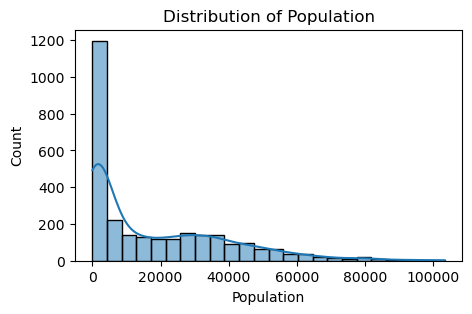

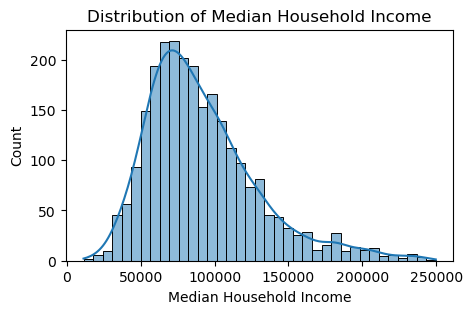

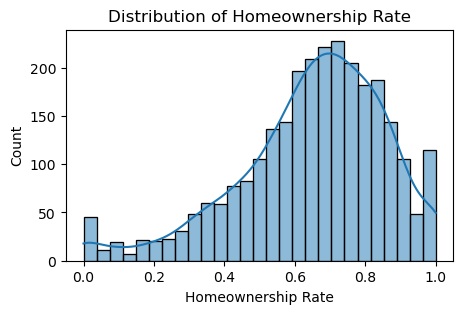

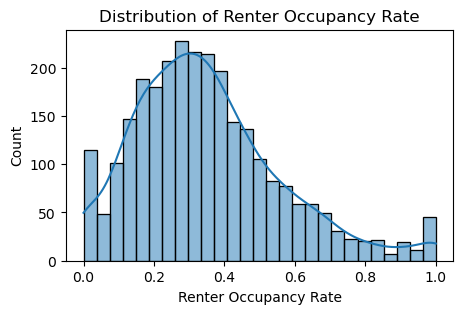

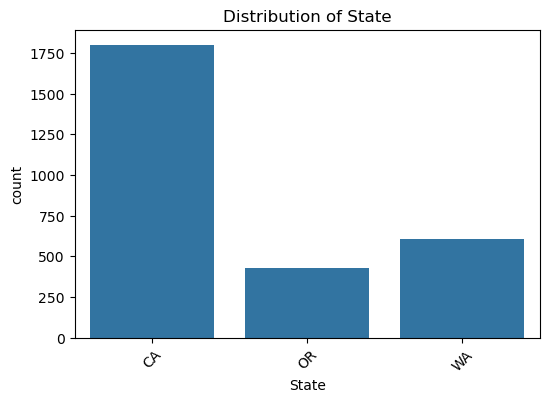

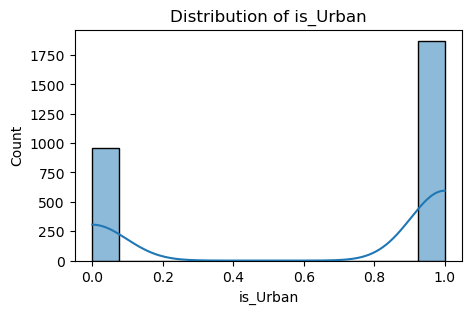

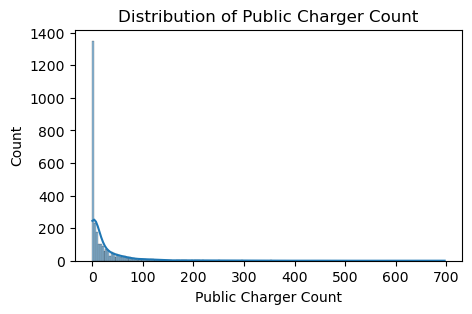

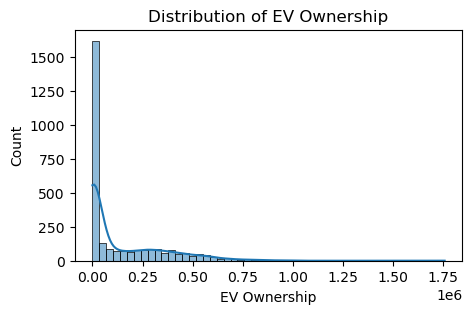

In [29]:
# Univariate Analysis
# Check distribution
for col in model_dataset.drop('ZIP Code', axis=1).columns:
    if model_dataset[col].dtype in ['int64', 'float64']:
        plt.figure(figsize=(5, 3))
        sns.histplot(model_dataset[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.show()

    elif model_dataset[col].dtype == 'object':
        plt.figure(figsize=(6, 4))
        sns.countplot(data=model_dataset, x=col)
        plt.title(f'Distribution of {col}')
        plt.xticks(rotation=45)
        plt.show()

Transformed Variables:


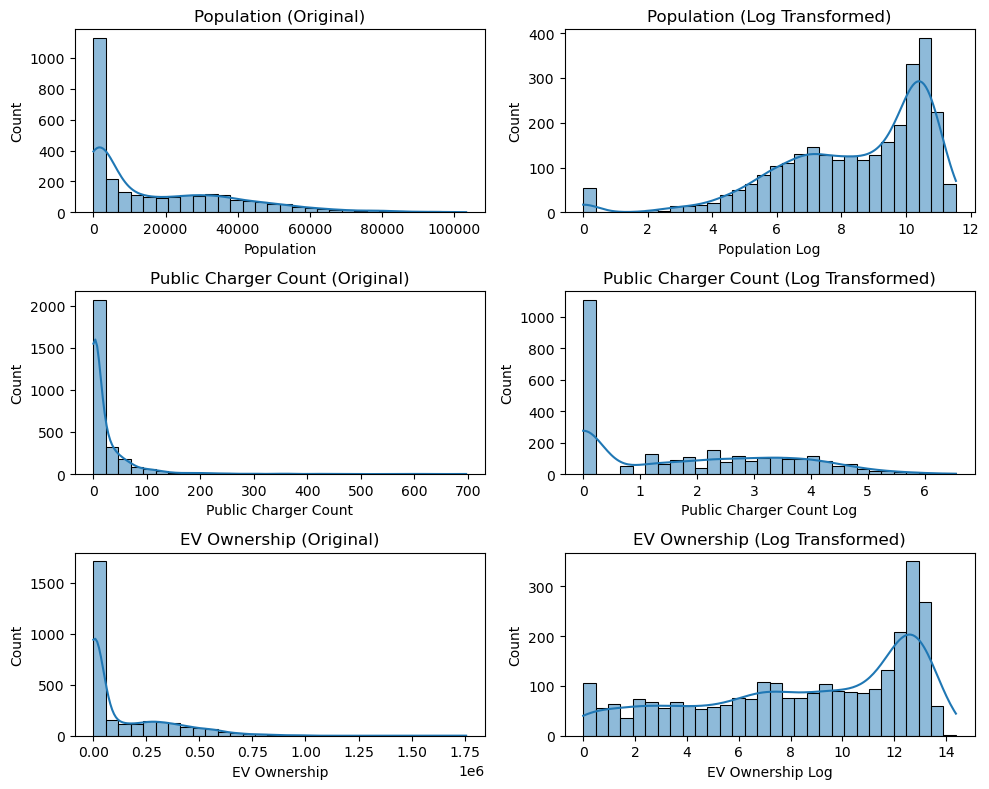

In [30]:
# Transform highly skewed variables with log(1 + x)

# Define transformed variables
columns_to_log = [
    ('Population', 'Population Log'),
    ('Public Charger Count', 'Public Charger Count Log'),
    ('EV Ownership', 'EV Ownership Log')
]

# Apply transformation
for original, log_col in columns_to_log:
    model_dataset[log_col] = np.log1p(model_dataset[original])

# Set subplot grid
fig, axes = plt.subplots(3, 2, figsize=(10, 8))
axes = axes.flatten()

print('Transformed Variables:')
# Loop through each variable and plot before/after
for i, (original, log_col) in enumerate(columns_to_log):
    # Original
    sns.histplot(model_dataset[original],
                 bins=30,
                 kde=True,
                 edgecolor='black',
                 ax=axes[2*i])
    axes[2*i].set_title(f'{original} (Original)')
    axes[2*i].set_xlabel(original)
    axes[2*i].set_ylabel('Count')

    # Transformed
    sns.histplot(model_dataset[log_col],
                 bins=30,
                 kde=True,
                 edgecolor='black',
                 ax=axes[2*i+1])
    axes[2*i+1].set_title(f'{original} (Log Transformed)')
    axes[2*i+1].set_xlabel(log_col)
    axes[2*i+1].set_ylabel('Count')

plt.tight_layout()
plt.show()

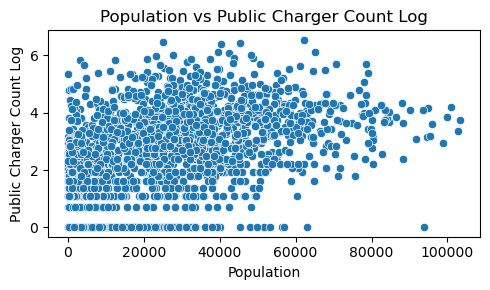

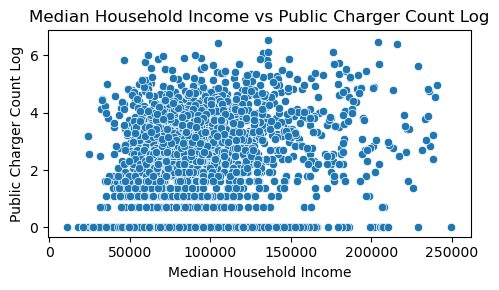

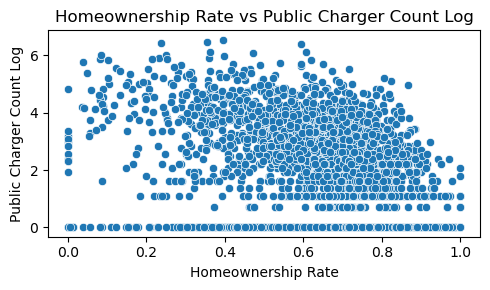

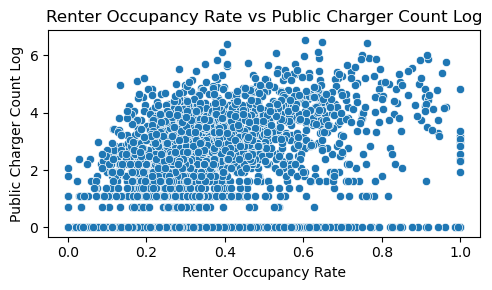

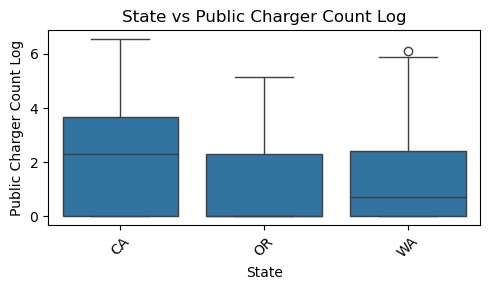

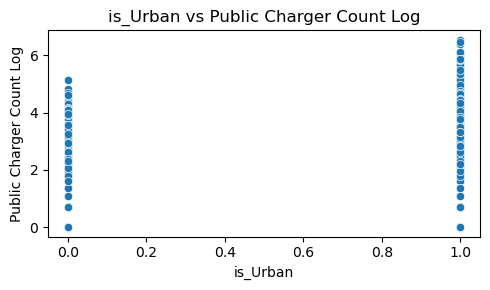

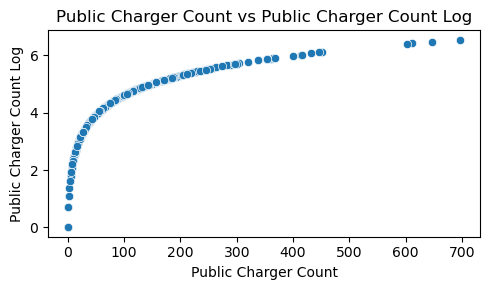

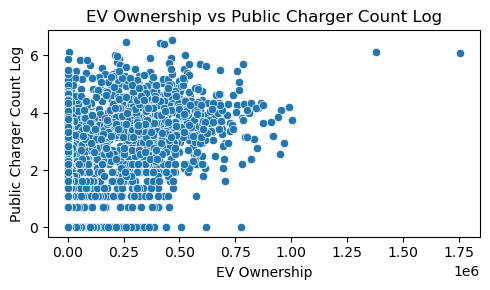

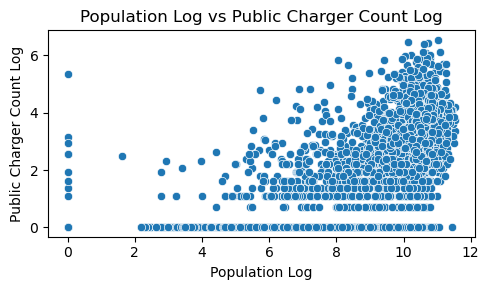

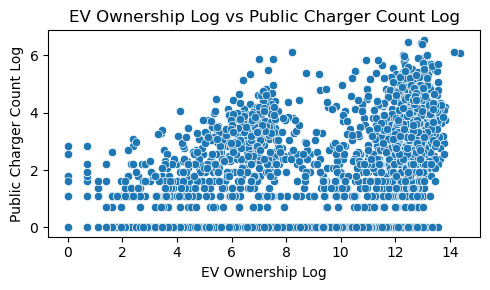

In [31]:
# Bivariate Analysis

# Define target variable
target = 'Public Charger Count Log'


for col in model_dataset.drop(['ZIP Code',
                               target], axis=1).columns:

    # Define figure size
    plt.figure(figsize=(5, 3))
    
    # Numeric predictors
    if model_dataset[col].dtype in ['int64', 'float64']:
        sns.scatterplot(data=model_dataset, x=col, y=target)
        plt.title(f'{col} vs {target}')
        plt.xlabel(col)
        plt.ylabel(target)
    
    # Categorical Predictors
    elif model_dataset[col].dtype == 'object':
        sns.boxplot(data=model_dataset, x=col, y=target)
        plt.title(f'{col} vs {target}')
        plt.xlabel(col)
        plt.ylabel(target)
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

## Data Preprocessing

In [33]:
# Define Charger to EV Ratio
model_dataset['Charger to EV Ratio'] = np.where(
    model_dataset['EV Ownership'] != 0,
    (model_dataset['Public Charger Count'] / model_dataset['EV Ownership']) * 1000,
    0 # Set values to zero if EV Ownership == 0
)

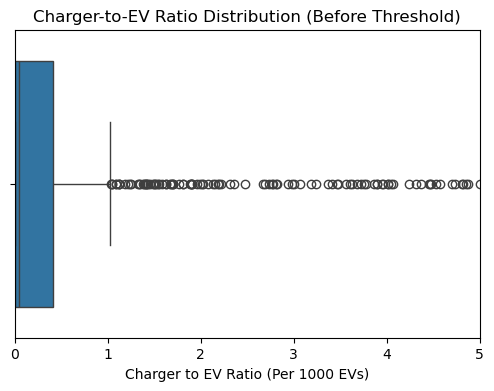

In [34]:
# Box plot of Charger to EV Ratio
plt.figure(figsize=(6, 4))
sns.boxplot(x=model_dataset['Charger to EV Ratio'])
plt.title('Charger-to-EV Ratio Distribution (Before Threshold)')
plt.xlabel('Charger to EV Ratio (Per 1000 EVs)')
plt.xlim(0, 5)
plt.show()

In [35]:
# Define top 25% threshold
threshold = model_dataset['Charger to EV Ratio'].quantile(0.75)

# Filter for top 25%
optimal_model_dataset = model_dataset[
    model_dataset['Charger to EV Ratio'] >= threshold
].reset_index(drop=True)

In [36]:
# Print threshold
print('Threshold (Per 1,000 EVs):', threshold)

Threshold (Per 1,000 EVs): 0.4113811841997561


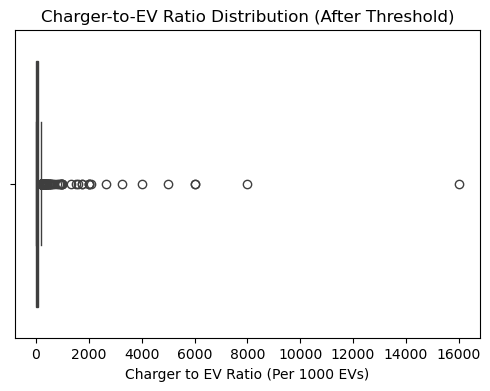

In [37]:
# Box plot of Charger to EV Ratio after applying threshold
plt.figure(figsize=(6, 4))
sns.boxplot(x=optimal_model_dataset['Charger to EV Ratio'])
plt.title('Charger-to-EV Ratio Distribution (After Threshold)')
plt.xlabel('Charger to EV Ratio (Per 1000 EVs)')
plt.show()

In [38]:
# Drop non-representative extreme upper outliers
upper_bound = optimal_model_dataset['Charger to EV Ratio'].quantile(0.90)
print(f'Upper bound defined as: {upper_bound:.0F} per 1,000 EVs')
optimal_model_dataset = optimal_model_dataset[optimal_model_dataset['Charger to EV Ratio'] <= upper_bound]

Upper bound defined as: 235 per 1,000 EVs


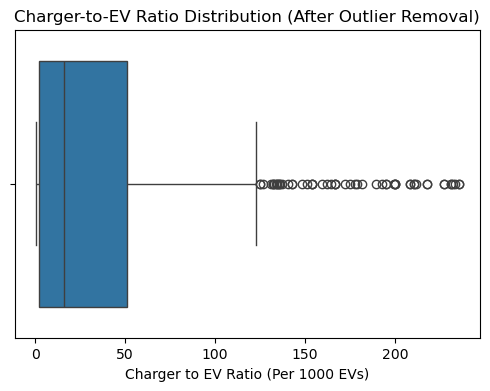

In [39]:
# Box plot of Charger to EV Ratio after applying threshold
plt.figure(figsize=(6, 4))
sns.boxplot(x=optimal_model_dataset['Charger to EV Ratio'])
plt.title('Charger-to-EV Ratio Distribution (After Outlier Removal)')
plt.xlabel('Charger to EV Ratio (Per 1000 EVs)')
plt.show()

In [40]:
# Define Predictor variables
X = [
    'Median Household Income',
    'Renter Occupancy Rate',
    'Homeownership Rate',
    'State',
    'Population Log',
    'EV Ownership Log',
    'is_Urban',

]

# Define Target variable
y = 'Public Charger Count'

# Define numeric columns
numeric_cols = [
    'Median Household Income',
    'Renter Occupancy Rate',
    'Homeownership Rate',
    'Population Log',
    'EV Ownership Log'
]

# Define categorical columns
cat_cols = ['State']

In [41]:
# Apply train test split
X_train, X_test, y_train, y_test = train_test_split(
    optimal_model_dataset[X],
    optimal_model_dataset[y],
    test_size=0.2,
    random_state=42
)

In [42]:
# Define Imputers, Encoders, and Transformations for the last remaining cleaning
# for Random Forest Model

# Define imputers
numeric_imputer = SimpleImputer(strategy='median')

# define encoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Define preproccessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_imputer, numeric_cols),
        ('cat', encoder, cat_cols)
    ], remainder='passthrough', force_int_remainder_cols=False)

# Define Random Forest Model and Transformation
model = TransformedTargetRegressor(
    regressor=RandomForestRegressor(random_state=42),
    transformer=FunctionTransformer(np.log1p, inverse_func=np.expm1)
)

# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

## Create Model and Apply Tuning Steps

In [44]:
# Use RandomizedCV

# Define Parameter distribution
# Use a wide distribution
param_grid = {
    'model__regressor__n_estimators': [100, 300, 500, 750, 1000], 
    'model__regressor__max_depth': [10, 20, 30, 50, None],              
    'model__regressor__min_samples_split': [2, 5, 10, 20],         
    'model__regressor__min_samples_leaf': [1, 2, 4, 6, 10, 20], 
    'model__regressor__max_features': ['sqrt', 'log2', 0.5, 0.75]    
}

# Create Random Search Model
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=500, # Large inter count
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Run search
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV] END model__regressor__max_depth=None, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=20, model__regressor__min_samples_split=20, model__regressor__n_estimators=500; total time=   0.4s
[CV] END model__regressor__max_depth=None, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=4, model__regressor__min_samples_split=20, model__regressor__n_estimators=750; total time=   1.2s
[CV] END model__regressor__max_depth=None, model__regressor__max_features=sqrt, model__regressor__min_samples_leaf=10, model__regressor__min_samples_split=20, model__regressor__n_estimators=1000; total time=   0.9s
[CV] END model__regressor__max_depth=10, model__regressor__max_features=log2, model__regressor__min_samples_leaf=1, model__regressor__min_samples_split=10, model__regressor__n_estimators=1000; total time=   1.1s
[CV] END model__regressor__max_depth=30, model__regressor__max_features=sqrt, mode

/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(force_int_remainder_cols=False,
                                                                remainder='passthrough',
                                                                transformers=[('num',
                                                                               SimpleImputer(strategy='median'),
                                                                               ['Median '
                                                                                'Household '
                                                                                'Income',
                                                                                'Renter '
                                                                                'Occupancy '
                                                                                'Rate',
                                                                                'Homeownership '
                                                                                'Rate',
                                                                                'Population '
                                                                                'Log',
                                                                                'EV '
                                                                                'Ownership '
                                                                                'Log']),
                                                                              ('cat',
                                                                               OrdinalEncoder(handle_unknown='u...
                                                                                                         inverse_func=<ufunc 'expm1'>)))]),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'model__regressor__max_depth': [10, 20,
                                                                        30, 50,
                                                                        None],
                                        'model__regressor__max_features': ['sqrt',
                                                                           'log2',
                                                                           0.5,
                                                                           0.75],
                                        'model__regressor__min_samples_leaf': [1,
                                                                               2,
                                                                               4,
                                                                               6,
                                                                               10,
                                                                               20],
                                        'model__regressor__min_samples_split': [2,
                                                                                5,
                                                                                10,
                                                                                20],
                                        'model__regressor__n_estimators': [100,
                                                                           300,
                                                                           500,
                                                                           750,
                                                                           1000]},
                   random_state=42, scoring='r2', verbose=2)

In [45]:
# Print Best validation metric
print("Best R-squared on Validation Set:", random_search.best_score_)

Best R-squared on Validation Set: 0.5906282282362978


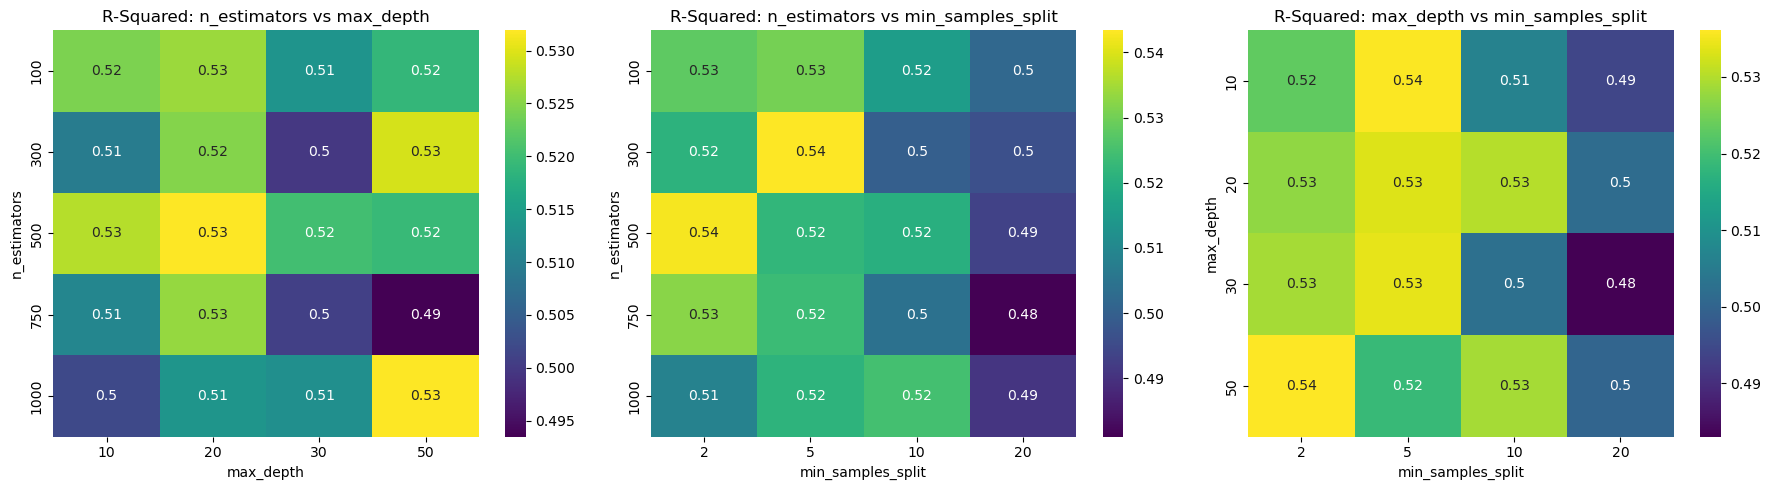

In [46]:
# Extract results
results_df = pd.DataFrame(random_search.cv_results_)

# Define pairs of parameters and titles
heatmap_specs = [
    ('param_model__regressor__n_estimators',
     'param_model__regressor__max_depth',
     "R-Squared: n_estimators vs max_depth"),
    ('param_model__regressor__n_estimators',
     'param_model__regressor__min_samples_split',
     "R-Squared: n_estimators vs min_samples_split"),
    ('param_model__regressor__max_depth',
     'param_model__regressor__min_samples_split',
     "R-Squared: max_depth vs min_samples_split"),
]

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loop through heatmap configs
for ax, (row_param, col_param, title) in zip(axes, heatmap_specs):
    pivot = results_df.pivot_table(
        values='mean_test_score',
        index=row_param,
        columns=col_param
    )
    sns.heatmap(pivot, annot=True, cmap='viridis', ax=ax)
    ax.set_title(title)
    ax.set_xlabel(col_param.split('__')[-1])
    ax.set_ylabel(row_param.split('__')[-1])

plt.tight_layout()
plt.show()


In [47]:
# Best parameters found
best_params = random_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'model__regressor__n_estimators': 100, 'model__regressor__min_samples_split': 2, 'model__regressor__min_samples_leaf': 2, 'model__regressor__max_features': 0.75, 'model__regressor__max_depth': 30}


In [48]:
# Define best model
best_model = random_search.best_estimator_

In [49]:
# Print Validation metric
print("Best R-squared on Validation Set:", random_search.best_score_)

Best R-squared on Validation Set: 0.5906282282362978


In [50]:
# Evaluate against testing set
y_pred = random_search.predict(X_test)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared on Test Set:", r2)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE on Test Set:", rmse)

R-squared on Test Set: 0.6721573172119434
RMSE on Test Set: 54.49558353532469


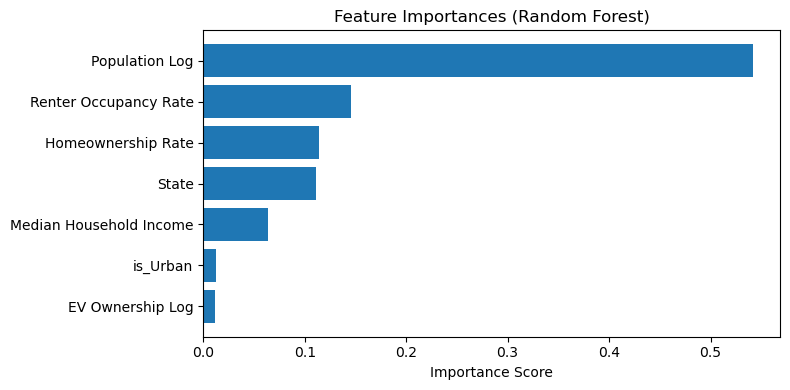

In [51]:
# List feature importance
importances = best_model.named_steps['model'].regressor_.feature_importances_
feature_names = X_train.columns

# Sort feature importances in descending order
indices = np.argsort(importances)

# Create horizontal bar chart
plt.figure(figsize=(8, 4))
plt.barh(range(len(importances)), importances[indices], align='center')
plt.yticks(range(len(importances)), feature_names[indices])
plt.xlabel('Importance Score')
plt.title('Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

In [52]:
# Evaluate Model with Statistical Testing
# Predict log-transformed charger counts
full_preds = best_model.predict(model_dataset[X])

# Round Predicted Output and convert to int
model_dataset['Predicted Optimal Public Charger Count'] = np.round(
    full_preds
    ).astype(int)

# Define Mask for Reasonably Predicted EV Chargers where:
# EV Ownership is above 0
# Population is at least 1000
mask = (
    (model_dataset['EV Ownership'] > 0) &
    (model_dataset['Population'] >= 1000)
)
model_dataset.loc[~mask, 'Predicted Optimal Public Charger Count'] = 0

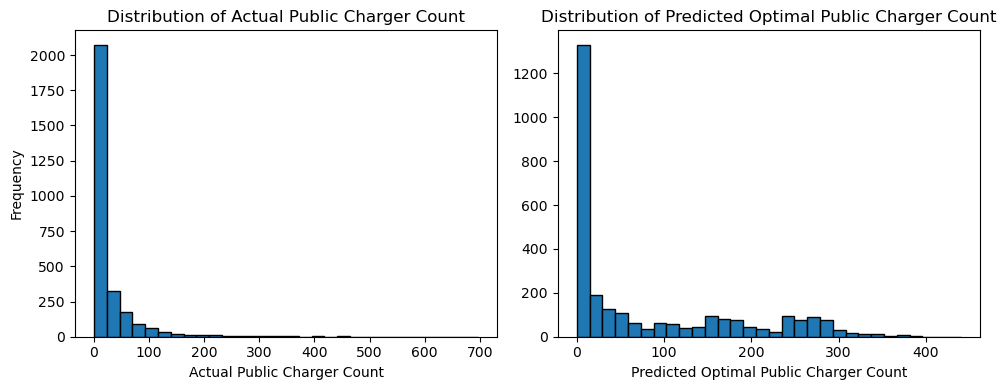

In [53]:
# Create the figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Histogram for Actual Charger Count
axes[0].hist(model_dataset['Public Charger Count'], bins=30, edgecolor='black')
axes[0].set_title('Distribution of Actual Public Charger Count')
axes[0].set_xlabel('Actual Public Charger Count')
axes[0].set_ylabel('Frequency')

# Histogram for Predicted Charger Count
axes[1].hist(model_dataset['Predicted Optimal Public Charger Count'], bins=30, edgecolor='black')
axes[1].set_title('Distribution of Predicted Optimal Public Charger Count')
axes[1].set_xlabel('Predicted Optimal Public Charger Count')

# Display
plt.tight_layout()
plt.show()

In [54]:
# Computer Diffrenece (Actual - Predicted Optimal)
residuals = (
    model_dataset['Public Charger Count'] -
    model_dataset['Predicted Optimal Public Charger Count']
)

# Check normality
_, p_value = stats.shapiro(residuals)

if p_value > 0.05:
    print("Residuals are normally distributed.")
else:
    print("Residuals are not normally distributed.")

Residuals are not normally distributed.


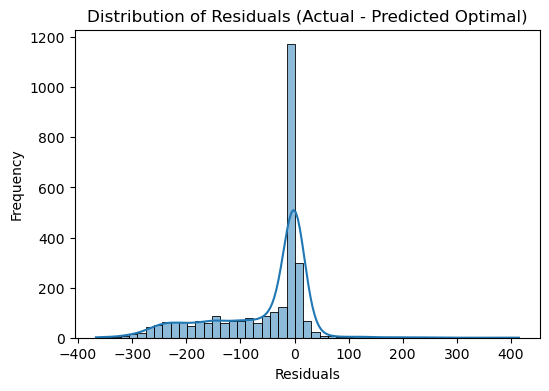

In [55]:
# Plot residuals
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals (Actual - Predicted Optimal)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [56]:
# Use Wilcoxon signed-rank test
stat, p_value = stats.wilcoxon(residuals)

print("Wilcoxon signed-rank test statistic:", stat)
print("p-value:", p_value)

Wilcoxon signed-rank test statistic: 278645.5
p-value: 9.530590758570292e-215


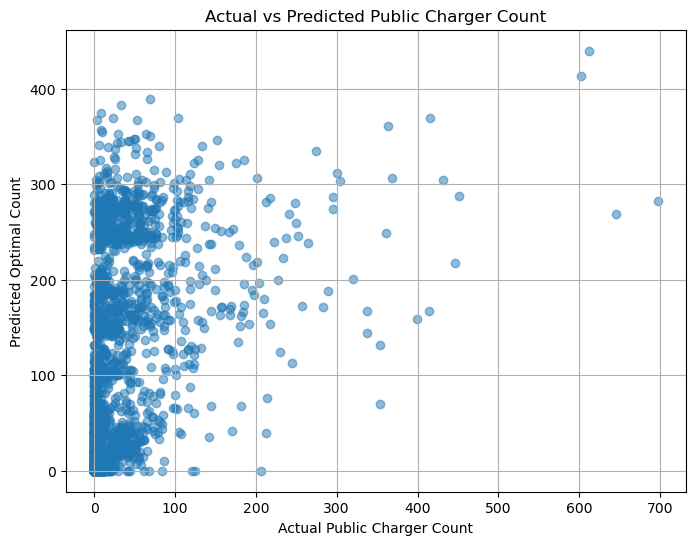

In [57]:
# Visualize differences in Predicted Vs. Actual Public Charger Counts
plt.figure(figsize=(8, 6))
plt.scatter(model_dataset['Public Charger Count'], model_dataset['Predicted Optimal Public Charger Count'], alpha=0.5)
plt.xlabel("Actual Public Charger Count")
plt.ylabel("Predicted Optimal Count")
plt.title("Actual vs Predicted Public Charger Count")
plt.grid(True)
plt.show()

In [58]:
# Export Dataset to CSV
model_dataset.to_csv('Model_Dataset.csv', index=False)